### DATAFRAME

In [1]:
from cloudvolume import CloudVolume
from meshparty import skeletonize, trimesh_io
from caveclient import CAVEclient
import trimesh
import numpy as np
import datetime
import networkx as nx
from scipy.sparse import identity
from scipy.spatial import distance_matrix
import scipy 
from tqdm import tqdm
# import aws
import pandas as pd
import csv
import pyembree
import matplotlib.pyplot as plt
import scipy.spatial as spatial
import itertools
import math
from IPython.display import display
from PIL import Image

In [2]:
orphans = pd.read_csv("/Users/sparkle7160/campfire/ALL_ORPHANS.csv")

In [3]:
orphans_subset = pd.read_csv("/Users/sparkle7160/campfire/Orphans_subset.csv")

In [4]:
def my_array(x):
    res = list(map(str.strip, x.split('; ')))
    return res

In [5]:
orphans['endpoints'] = orphans['endpoints'].map(lambda x: list(map(str.strip, x.split('; '))))

In [6]:
orphans_subset['endpoints'] = orphans_subset['endpoints'].map(lambda x: list(map(str.strip, x.split('; '))))

In [7]:
## convert from string list to 2-d array
def convert_to_array(row):
    count = 0
    result = []
    for endpoint in row["endpoints"]:
        endpoint = eval(endpoint)
        if(count == 0):
            result = np.array(endpoint)
            count = count + 1
        else:
            result = np.vstack((result, np.array(endpoint)))
            count = count + 1
    if(count == 1 and result.size != 0):
        result = result.reshape(1,3)
    return result 

In [8]:
orphans["real_endpoints"] = orphans.apply(convert_to_array, axis = 1)

In [9]:
orphans_subset["real_endpoints"] = orphans_subset.apply(convert_to_array, axis = 1)

### TIP FINDER FUNCTIONS

In [10]:
def get_and_process_mesh(root_id):
    datastack_name = "minnie65_phase3_v1"
    client = CAVEclient(datastack_name)
    vol = CloudVolume(
        client.info.segmentation_source(),
        use_https=True,
        progress=False,
        bounded=False,
        fill_missing=True,
        secrets={"token": client.auth.token}
    )
    print("Downloading Mesh")
    mesh = vol.mesh.get(str(root_id))[root_id]
    mesh_obj = trimesh.Trimesh(np.divide(mesh.vertices, np.array([1,1,1])), mesh.faces)
    print("Vertices: ", mesh.vertices.shape[0])

    if mesh_obj.volume > 4000000000000:
        print("TOO BIG, SKIPPING")
        return None
    trimesh.repair.fix_normals(mesh_obj)
    mesh_obj.fill_holes()

    return mesh_obj

In [11]:
def get_soma(soma_id:str):
    cave_client = CAVEclient('minnie65_phase3_v1')
    soma = cave_client.materialize.query_table(
        "nucleus_neuron_svm",
        filter_equal_dict={'id':soma_id}
    )
    return soma

In [12]:
def process_mesh_ccs(mesh_obj):
    print("Processing CC's")
    ccs_graph = trimesh.graph.connected_components(mesh_obj.edges)
    ccs_len = [len(c) for c in ccs_graph]
    largest_component = ccs_graph[np.argmax(ccs_len)]
    largest_component_remap = np.arange(ccs_graph[np.argmax(ccs_len)].shape[0])
    face_dict = {largest_component[i]:largest_component_remap[i] for i in range(largest_component.shape[0])}

    new_faces_mask = np.isin(mesh_obj.faces, list(face_dict.keys()))
    new_faces_mask = new_faces_mask[:, 0]*new_faces_mask[:, 1]*new_faces_mask[:, 2]

    new_faces = np.vectorize(face_dict.get)(mesh_obj.faces[new_faces_mask])
    new_faces = new_faces[new_faces[:, 0] != None]
    largest_component_mesh = trimesh.Trimesh(mesh_obj.vertices[largest_component], new_faces)

    all_ids = set(largest_component)
    encapsulated_ids = []

    for i in range(1, len(ccs_graph)):
        n_con = largest_component_mesh.contains(mesh_obj.vertices[ccs_graph[i]])
        if np.sum(n_con) / n_con.shape[0] == 0 and n_con.shape[0] > 50:
            all_ids.update(ccs_graph[i])
        else:
            if len(ccs_graph[i]) < 1000:
                encapsulated_ids.append((np.mean(mesh_obj.vertices[ccs_graph[i]], axis=0)/[4,4,40], len(ccs_graph[i])))
            
    all_component = np.array(list(ccs_graph[np.argmax(ccs_len)]))
    all_component_remap = np.arange(all_component.shape[0])
    face_dict = {all_component[i]:all_component_remap[i] for i in range(all_component.shape[0])}
    new_faces_mask = np.isin(mesh_obj.faces, list(face_dict.keys()))
    new_faces_mask = new_faces_mask[:, 0]*new_faces_mask[:, 1]*new_faces_mask[:, 2]

    new_faces = np.vectorize(face_dict.get)(mesh_obj.faces[new_faces_mask])
    new_faces[new_faces[:, 0] != None]
    
    largest_component_mesh = trimesh.Trimesh(mesh_obj.vertices[all_component], new_faces)
    
    mesh_obj = largest_component_mesh
    return mesh_obj, encapsulated_ids, np.max(ccs_len)

In [13]:
def process_defects(mesh_obj, a=.75):
    bad_edges = trimesh.grouping.group_rows(
        mesh_obj.edges_sorted, require_count=1)
    bad_edges_ind = mesh_obj.edges[bad_edges]
    sparse_edges = mesh_obj.edges_sparse
    xs = list(bad_edges_ind[:, 0]) + list(bad_edges_ind[:, 1]) 
    ys = list(bad_edges_ind[:, 1]) + list(bad_edges_ind[:, 0])
    vs = [1]*bad_edges_ind.shape[0]*2
    bad_inds = scipy.sparse.coo_matrix((vs, (xs, ys)), shape=(mesh_obj.vertices.shape[0], mesh_obj.vertices.shape[0]))
    # Make it symmetrical and add identity so each integrates from itself too, then subtract singleton edges
    # I noticed that the number of asymmetrical edges vs the number of single edges I find from group rows
    # Are close but different. Haven't looked into that yet. Also removing edges 1 hop away from single edges to remove bias towards
    # Holes in the mesh that are caused by mesh construction errors as opposed to segmentation errors
    sparse_edges = mesh_obj.edges_sparse + mesh_obj.edges_sparse.T + identity(mesh_obj.edges_sparse.shape[0]) - sparse_edges.multiply(bad_inds) - bad_inds
    degs = mesh_obj.vertex_degree + 1

    # N_iter is a smoothing parameter here. The loop below smooths the vertex error about the mesh to get more consistent connected regions
    n_iter = 2
    angle_sum = np.array(abs(mesh_obj.face_angles_sparse).sum(axis=1)).flatten()
    defs = (2 * np.pi) - angle_sum

    abs_defs = np.abs(defs)
    abs_defs_i = abs_defs.copy()
    for i in range(n_iter):
        abs_defs_i = sparse_edges.dot(abs_defs_i) / degs
    
    verts_select = np.argwhere((abs_defs_i > a))# & (abs_defs < 2.5))

    edges_mask = np.isin(mesh_obj.edges, verts_select)
    edges_mask[bad_edges] = False
    edges_select = edges_mask[:, 0] * edges_mask[:, 1]
    edges_select = mesh_obj.edges[edges_select]

    G = nx.from_edgelist(edges_select)#f_edge_sub)

    ccs = nx.connected_components(G)
    subgraphs = [G.subgraph(cc).copy() for cc in ccs]

    lens = []
    lengths = []
    for i in tqdm(range(len(subgraphs))):
        ns = np.array(list(subgraphs[i].nodes()))
    #     ns = ns[abs_defs[ns ]]
        l = len(ns)
        if l > 20 and l < 5000:
            lens.append(ns)
            lengths.append(l)
    all_nodes = set()
    for l in lens:
        all_nodes.update(l)
    all_nodes = np.array(list(all_nodes))
    # sharp_pts = mesh_obj.vertices[all_nodes]
    centers = np.array([np.mean(mesh_obj.vertices[list(ppts)],axis=0) for ppts in lens])

    return centers, lens

In [14]:
def process_endpoints(mesh_obj, skel_mp):
    # Process the skeleton to get the endpoints
    interior_cc_mask = set()
    el = nx.from_edgelist(skel_mp.edges)
    comps = list(nx.connected_components(el))
    for c in comps:
        if len(c) < 100:
            n_con = mesh_obj.contains(skel_mp.vertices[list(c)])
            if np.sum(n_con) / n_con.shape[0] > .10:
                interior_cc_mask.update(list(c))
    # Process the skeleton to get the endpoints
    edges = skel_mp.edges.copy()

    edge_mask = ~np.isin(edges, interior_cc_mask)
    edge_mask = edge_mask[:, 0] + edge_mask[:, 1]
    edges = edges[edge_mask]
    edges_flat  = edges.flatten()
    edge_bins = np.bincount(edges_flat) 

    eps = np.squeeze(np.argwhere(edge_bins==1))
    eps_nm = skel_mp.vertices[eps]

    eps_comp = distance_matrix(eps_nm, eps_nm)
    eps_comp[eps_comp == 0] = np.inf
    eps_thresh = np.argwhere(~(np.min(eps_comp, axis=0) < 3000))

    eps = np.squeeze(eps[eps_thresh])
    eps_nm = np.squeeze(eps_nm[eps_thresh])
    return eps, eps_nm

In [15]:
def process_mesh_errors(mesh_obj, centers, eps, eps_nm, lens, skel_mp):
    if eps.size == 1:
        #eps_nm should therefore be reshaped
        eps_nm = eps_nm.reshape((1,3))

    print("Processing mesh errors")
    # path_to_root_dict = {}
    # for ep in eps:
    #     path_to_root_dict[ep] = skel_mp.path_to_root(ep)
        
    dists_defects = np.zeros(centers.shape[0])
    sizes = np.zeros(centers.shape[0])
    mesh_map = skel_mp.mesh_to_skel_map
    closest_skel_pts = mesh_map[[l[0] for l in lens]]

    # print(centers, eps_nm)

    dist_matrix = distance_matrix(centers, eps_nm)
    ct = 0

    closest_tip = np.zeros((centers.shape[0]))

    for center in tqdm(centers):
    #     skel_pts_dists = np.linalg.norm(skel_mp.vertices - center, axis=1)
    #     ep_pts_dists = np.linalg.norm(eps_nm - center, axis=1)
        
        # closest_skel_pt = closest_skel_pts[ct]
        min_ep = np.inf
        eps_hit = []
        if eps.size == 1:
            eps_hit.append(eps)
        else: 
            for j, ep in enumerate(eps):
                # if closest_skel_pt in path_to_root_dict[ep]:
                #     eps_hit.append(j)
                eps_hit.append(j)
        
        if(eps.size == 1):
            dists = dist_matrix[ct]
        else:
            dists = dist_matrix[ct, eps_hit]
        
        amin = np.argmin(dists)
        tip_hit = eps_hit[amin]
        min_dist = dists[amin]
        
        closest_tip[ct] = tip_hit
    #     print(np.argmin(ep_pts_dists), ep_found, eps_nm[np.argmin(ep_pts_dists)]/[4,4,40], eps_nm[j]/[4,4,40], center/[4,4,40])
        dists_defects[ct] = min_dist
        sizes[ct] = len(lens[ct])
        ct+=1
    dists_defects_sub = dists_defects[dists_defects < 5000]
    sizes_sub = sizes[dists_defects < 5000]
    centers_sub = centers[dists_defects < 5000]
    tips_hit_sub = closest_tip[dists_defects < 5000]
    closest_skel_pts_sub = closest_skel_pts[dists_defects < 5000]
    inds_sub = np.arange(centers.shape[0])[dists_defects < 5000]


    # Also ranking each component based on its PCA- if the first component is big enough, the points are mostly linear
    # These point sets seem to be less likely to be true errors
    from sklearn.decomposition import PCA
    pca_vec = np.zeros(inds_sub.shape[0])
    for i in range(inds_sub.shape[0]):
        pca = PCA()#n_components=2)
        pca.fit(mesh_obj.vertices[lens[inds_sub[i]]])

        pca_vec[i] = pca.explained_variance_ratio_[0]

    dists_defects_sub[dists_defects_sub < 4000] = 100
    dists_defects_norm = dists_defects_sub #/ np.max(dists_defects_sub)
    ranks_ep = sizes_sub / dists_defects_norm * (1-pca_vec)
    ranks = sizes_sub**2 * (1-pca_vec)

    #ranks_ep_errors_filt = ranks_ep[ranks_ep > .1]
    centers_ep_send_errors = centers_sub[np.argsort(ranks_ep)][::-1][:20]
    final_mask_eps = np.full(centers_ep_send_errors.shape[0], True)
    tips_hit_send_ep = tips_hit_sub[np.argsort(ranks_ep)][::-1][:20]
    uns, nums = np.unique(tips_hit_send_ep, return_counts=True)

    for un, num in zip(uns, nums):
        if num > 1:
            final_mask_eps[np.argwhere(tips_hit_send_ep == un)[1:]] = False
    centers_errors_ep = centers_ep_send_errors[final_mask_eps]
    centers_errors = centers_sub[np.argsort(ranks)[::-1]][:20]
    return centers_errors, centers_errors_ep

In [16]:
def process_mesh_facets(mesh_obj, skel_mp, eps, eps_nm, facet_area_threshold=30000):

    
    if eps.size == 1:
        #eps_nm should therefore be reshaped
        eps_nm = eps_nm.reshape((1,3))

    #changed threshold of facets to 3000 to match changes performed on processed in analysis CELLS
    print("Processing facets")
    #can possibly change param here
    #threshold on size of flat area
    locs = np.argwhere(mesh_obj.facets_area > facet_area_threshold)

    mesh_map = skel_mp.mesh_to_skel_map
    mesh_coords = mesh_obj.vertices[mesh_obj.faces]
    mean_locs = []
    mesh_ind = []
    fs = []
    for l in tqdm(locs):
        fs.append(np.sum(mesh_obj.facets_area[l]))
        fc = mesh_obj.facets[l[0]]
        vert_locs = mesh_coords[fc]
        mean_locs.append(np.mean(vert_locs[:, 0], axis=0))
        mesh_ind.append(fc[0])
    mesh_ind = mesh_obj.faces[mesh_ind][:, 0]
    mean_locs = np.array(mean_locs)
    if mean_locs.size == 0:
        facets_send_final = np.zeros((1,3))
        return facets_send_final
    dists_defects_facets = np.zeros(mean_locs.shape[0])
    mesh_map_facets = skel_mp.mesh_to_skel_map
    closest_skel_pts_facets = mesh_map[[m for m in mesh_ind]]
    dist_matrix_facets = distance_matrix(mean_locs, eps_nm)
    ct = 0

    closest_tip_facets = np.zeros((mean_locs.shape[0]))

    for center in tqdm(mean_locs):

        closest_skel_pt = closest_skel_pts_facets[ct]
        eps_hit = []
        ##added for error fixing
        if eps.size == 1:
            eps_hit.append(eps)
        else:
            for j, ep in enumerate(eps):
                # if closest_skel_pt in path_to_root_dict[ep]:
                #     eps_hit.append(j)
                eps_hit.append(j)
        
            #distance from every error(facets and jagged) to every endpoint
        if(eps.size == 1):
            dists = dist_matrix_facets[ct]
        else:
            dists = dist_matrix_facets[ct, eps_hit]
    
        
        amin = np.argmin(dists)
        tip_hit = eps_hit[amin]
        min_dist = dists[amin]
        
        closest_tip_facets[ct] = tip_hit
        dists_defects_facets[ct] = min_dist
        ct+=1
    dists_defects_sub_facets = dists_defects_facets[dists_defects_facets < 2000]
    sizes_sub_facets = np.array(fs)[dists_defects_facets < 2000]
    mean_locs_facets = mean_locs[dists_defects_facets < 2000]
    tips_hit_sub_facets = closest_tip_facets[dists_defects_facets < 2000]
    closest_skel_pts_sub_facets = closest_skel_pts_facets[dists_defects_facets < 2000]
    inds_sub_facets = np.arange(mean_locs.shape[0])[dists_defects_facets < 2000]
    # ranks_ep_facets = sizes_sub_facets**2 / dists_defects_sub_facets
    #ranks_ep_facets_filt = ranks_ep_facets[ranks_ep_facets > 2e7]
    mean_locs_send_facets = mean_locs_facets
    final_mask_facets = np.full(mean_locs_send_facets.shape[0], True)
    tips_hit_send_facets = tips_hit_sub_facets
    uns, nums = np.unique(tips_hit_send_facets, return_counts=True)

    for un, num in zip(uns, nums):
        if num > 1:
            final_mask_facets[np.argwhere(tips_hit_send_facets == un)[1:]] = False
    facets_send_final = mean_locs_send_facets[final_mask_facets] / [4,4,40]
    return facets_send_final

### TIP FINDER FUNCTION

In [17]:
def error_locs_defects(root_id, soma_id = None, soma_table=None, center_collapse=True):
    mesh_obj = get_and_process_mesh(root_id)
    if mesh_obj is None:
        return None
    try:
        if soma_table==None:
            soma_table = get_soma(str(soma_id))
        if soma_table[soma_table.id == soma_id].shape[0] > 0:
            center = np.array(soma_table[soma_table.id == soma_id].pt_position)[0] * [4,4,40]
        else:
            center=None
    except:
        center = None
    print("Subselecting largest connected component of mesh")
    mesh_obj, encapsulated_ids, max_verts = process_mesh_ccs(mesh_obj)
    

    skel_mp = skeletonize.skeletonize_mesh(trimesh_io.Mesh(mesh_obj.vertices, 
                                            mesh_obj.faces),
                                            invalidation_d=4000,
                                            shape_function='cone',
                                            collapse_function='branch',
#                                             soma_radius = soma_radius,
                                            soma_pt=center,
                                            smooth_neighborhood=5,
                                             cc_vertex_thresh=max_verts - 10
#                                                     collapse_params = {'dynamic_threshold':True}
                                            )
    print("Skel done")
    centers, lens = process_defects(mesh_obj)
    eps, eps_nm = process_endpoints(mesh_obj, skel_mp)

    if(len(eps) == 0):
        sorted_encapsulated_send = np.zeros((1,3))
        facets_send_final = np.zeros((1,3))
        errors_send = np.zeros((1,3))
        errors_tips_send = np.zeros((1,3))
        return sorted_encapsulated_send, facets_send_final, errors_send, errors_tips_send
        
    
    if len(centers) !=0:
        centers_errors, centers_errors_ep = process_mesh_errors(mesh_obj, centers, eps, eps_nm, lens, skel_mp)
    else:
        centers_errors = np.zeros ((1,3))
        centers_errors_ep = np.zeros ((1,3))
        ranks = np.zeros ((1))
        ranks_ep = np.zeros((1, 3))
        ranks_return = 0
        ranks_ep_return = 0
    facets_send_final = process_mesh_facets(mesh_obj, skel_mp, eps, eps_nm)
    errors_send = centers_errors / [4,4,40]
    errors_tips_send = centers_errors_ep / [4,4,40]
    encapsulated_centers = [e[0] for e in encapsulated_ids]
    encapsulated_lens = [e[1] for e in encapsulated_ids]
    sorted_encapsulated_send = np.array(encapsulated_centers)[np.argsort(encapsulated_lens)][::-1]
    return sorted_encapsulated_send, facets_send_final, errors_send, errors_tips_send

### Generating Endpoints

In [18]:
def find_endpoints_and_counts(row):
    from scipy.spatial import distance_matrix

    seg_id = row["seg_id"]
    sorted_encapsulated_send, facets_send_final, errors_send, errors_tips_send = error_locs_defects(seg_id)
    
    together = np.vstack((facets_send_final, errors_tips_send))
    if len(together) == 0 or np.all(together == 0):
        num_points_error_tips_send = 0
        num_points_facets_send_final = 0
        together = np.zeros((1,3))
        return together, num_points_error_tips_send, num_points_facets_send_final, facets_send_final, errors_tips_send

    num_points_error_tips_send  = np.sum(np.all(errors_tips_send != 0, axis=1))
    num_points_facets_send_final = np.sum(np.all(facets_send_final != 0, axis=1))
    mask = np.sum(together, axis=1)
    together = together[mask > 0]


    return together, num_points_error_tips_send, num_points_facets_send_final, facets_send_final, errors_tips_send   

In [19]:
def generate_endpoints(dataframe):
    dataframe["endpoints_generated"], dataframe["num_errors"], dataframe["num_facets"], dataframe["facets"], dataframe["errors"] = zip(*dataframe.apply(find_endpoints_and_counts, axis=1))
    return dataframe

### Accuracy Function

In [20]:
def pred_eps_acc(gt_endpoints, pred_endpoints, threshold):
    # Calculate distances
    dist_matrix = np.array(spatial.distance.cdist(gt_endpoints, pred_endpoints, metric = 'euclidean'))
    # Apply threshold
    dist_matrix[dist_matrix > threshold] = 0
    # Calculating accuracy
    valid_eps = np.count_nonzero(dist_matrix, axis = 1)
    accuracy = np.count_nonzero(valid_eps) / len(gt_endpoints)
    return accuracy

### Filtering Facets + Errors Function

This function iterates through the given dataframe with the generated endpoints. Sometimes an "error" and "facet" can be placed close to one another and represent the same "true" endpoint. This function filters any close together errors and facets and chooses only one of them to represent the true endpoint. (point closest to gt endpoint is the one chosen)

In [21]:
def filter_facets_errors(row):
    filtered_points = []
    if len(row["endpoints_generated"]) == 0 or np.all(row["endpoints_generated"] == 0):
        filtered_points = np.zeros((1,3))
        return filtered_points, row["num_facets"], row["num_errors"], row["facets"], row["errors"] 
    # distance matrix calculation between all points in together
    dists = distance_matrix(row["endpoints_generated"], row["endpoints_generated"], p=2)
    #distance matrix between all points in together and true endpoints
    dists_to_gt = distance_matrix(row["endpoints_generated"], row["real_endpoints"])
    #filtered points keeps one point based on a threshold. Any other points within threshold is not kept
    N = row["endpoints_generated"].shape[0]  # Number of points
    filtered_indices = []

    for i in range(N):
        if i in filtered_indices:
            continue
        keep_index = i
        for j in range(i + 1, N):
            if j in filtered_indices:
                continue
            distance = dists[i, j]
            if distance <= 250 and distance > 0:
                #pick the endpoint closest to the gt endpoint
                #dist j to gt
                min_dist = np.min(dists_to_gt[keep_index])
                min_dist_2 = np.min(dists_to_gt[j])
                if min_dist <= min_dist_2:
                    #i is better than j
                    keep_index = i
                    filtered_indices.append(j)
                else:
                    #j is better than i
                    keep_index = j
                    filtered_indices.append(i)
        #out of the group of clustered points, this is closest to gt so we keep it and filter others out
        filtered_points.append(row["endpoints_generated"][keep_index])
        
    filtered_points = np.array(filtered_points)
    filtered_points = np.unique(filtered_points, axis = 0)

    if len(filtered_points) == 0:
        filtered_points =filtered_points.reshape((0, 3))

    #update the num_errors	num_facets	facets	errors
    for index in filtered_indices:
        if np.isin(row["endpoints_generated"][index], row["errors"]).any():
            #remove errors and decremeent count
            row["errors"] = row["errors"][row["errors"] != row["endpoints_generated"][index]]
            row["num_errors"] = row["num_errors"] - 1
        else:
            #remove from facets and decrement count
            row["facets"] = row["facets"][row["facets"] != row["endpoints_generated"][index]]
            row["num_facets"] = row["num_facets"] - 1

    return filtered_points, row["num_facets"], row["num_errors"], row["facets"], row["errors"]

### Testing On Orphans

In [22]:
generate_endpoints(orphans)

Vertices:  7993
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 7992/7992 [00:00<00:00, 312674.34it/s]


Skel done


100%|██████████| 26/26 [00:00<00:00, 15249.88it/s]

Processing facets



100%|██████████| 17/17 [00:00<00:00, 9680.04it/s]


Vertices:  21335
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 21334/21334 [00:00<00:00, 161399.69it/s]


Skel done


100%|██████████| 86/86 [00:00<00:00, 31251.96it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 3082.91it/s]


Processing facets


100%|██████████| 89/89 [00:00<00:00, 20076.00it/s]


Vertices:  2282
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 2281/2281 [00:00<00:00, 255057.52it/s]


Skel done


100%|██████████| 11/11 [00:00<00:00, 17799.90it/s]


Vertices:  185182
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!


Skel done


100%|██████████| 785/785 [00:00<00:00, 144326.86it/s]


Processing mesh errors


100%|██████████| 48/48 [00:00<00:00, 14319.10it/s]


Processing facets


100%|██████████| 1002/1002 [00:00<00:00, 26965.06it/s]


Vertices:  234
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 233/233 [00:00<00:00, 53490.58it/s]


Skel done


100%|██████████| 2/2 [00:00<00:00, 3874.65it/s]


Vertices:  1451
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 1450/1450 [00:00<00:00, 160189.14it/s]


Skel done


100%|██████████| 6/6 [00:00<00:00, 13573.80it/s]


Vertices:  1180
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 1179/1179 [00:00<00:00, 146096.80it/s]


Skel done


100%|██████████| 9/9 [00:00<00:00, 31145.82it/s]


Processing mesh errors


100%|██████████| 1/1 [00:00<00:00, 3721.65it/s]


Processing facets


100%|██████████| 9/9 [00:00<00:00, 7482.41it/s]


Vertices:  68105
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 68066/68066 [00:01<00:00, 35881.77it/s] 


Skel done


100%|██████████| 428/428 [00:00<00:00, 99642.66it/s]


Processing mesh errors


100%|██████████| 41/41 [00:00<00:00, 13950.39it/s]


Processing facets


100%|██████████| 328/328 [00:00<00:00, 22210.36it/s]


Vertices:  677
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 676/676 [00:00<00:00, 106512.00it/s]


Skel done


100%|██████████| 4/4 [00:00<00:00, 4672.02it/s]


Vertices:  11725
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 11724/11724 [00:00<00:00, 180149.69it/s]


Skel done


100%|██████████| 44/44 [00:00<00:00, 34188.47it/s]


Processing mesh errors


100%|██████████| 3/3 [00:00<00:00, 2749.76it/s]


Processing facets


100%|██████████| 47/47 [00:00<00:00, 12316.15it/s]


Vertices:  14714


Mesh is non-watertight for contained point query!


Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 14505/14505 [00:00<00:00, 305387.49it/s]


Skel done


100%|██████████| 91/91 [00:00<00:00, 24099.11it/s]


Processing mesh errors


100%|██████████| 9/9 [00:00<00:00, 3180.18it/s]


Processing facets


100%|██████████| 52/52 [00:00<00:00, 17491.68it/s]


Vertices:  24966
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 24965/24965 [00:00<00:00, 206847.18it/s]


Skel done


100%|██████████| 158/158 [00:00<00:00, 36958.34it/s]


Processing mesh errors


100%|██████████| 11/11 [00:00<00:00, 8403.89it/s]


Processing facets


100%|██████████| 89/89 [00:00<00:00, 21451.16it/s]


Vertices:  23312
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 23105/23105 [00:00<00:00, 205833.71it/s]


Skel done


100%|██████████| 168/168 [00:00<00:00, 100134.02it/s]


Processing mesh errors


100%|██████████| 13/13 [00:00<00:00, 9557.57it/s]


Processing facets


100%|██████████| 71/71 [00:00<00:00, 15710.66it/s]


Vertices:  171
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 170/170 [00:00<00:00, 33865.19it/s]


Skel done


100%|██████████| 1/1 [00:00<00:00, 1663.75it/s]


Vertices:  316
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 315/315 [00:00<00:00, 54928.94it/s]


Skel done


100%|██████████| 2/2 [00:00<00:00, 1919.15it/s]


Vertices:  2490
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 2489/2489 [00:00<00:00, 182103.38it/s]


Skel done


100%|██████████| 21/21 [00:00<00:00, 34272.52it/s]
Mesh is non-watertight for contained point query!


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 2222.15it/s]


Processing facets


100%|██████████| 5/5 [00:00<00:00, 5181.99it/s]


Vertices:  67
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 66/66 [00:00<00:00, 16491.37it/s]


Skel done


0it [00:00, ?it/s]


Vertices:  167
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 166/166 [00:00<00:00, 47581.12it/s]


Skel done


100%|██████████| 3/3 [00:00<00:00, 7025.63it/s]


Vertices:  413
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 412/412 [00:00<00:00, 48470.02it/s]


Skel done


100%|██████████| 2/2 [00:00<00:00, 1460.67it/s]


Vertices:  46191
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 46171/46171 [00:00<00:00, 100592.79it/s]


Skel done


100%|██████████| 199/199 [00:00<00:00, 103108.89it/s]


Processing mesh errors


100%|██████████| 17/17 [00:00<00:00, 10018.71it/s]


Processing facets


100%|██████████| 141/141 [00:00<00:00, 15599.61it/s]


Vertices:  7233
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 7232/7232 [00:00<00:00, 236100.18it/s]


Skel done


100%|██████████| 50/50 [00:00<00:00, 39338.81it/s]


Processing facets


100%|██████████| 6/6 [00:00<00:00, 6036.42it/s]


Vertices:  80
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 79/79 [00:00<00:00, 9989.75it/s]


Skel done


100%|██████████| 1/1 [00:00<00:00, 4100.00it/s]


Vertices:  1113
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 1112/1112 [00:00<00:00, 107864.62it/s]


Skel done


100%|██████████| 3/3 [00:00<00:00, 3580.79it/s]


Vertices:  2238
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 2237/2237 [00:00<00:00, 131185.62it/s]


Skel done


100%|██████████| 8/8 [00:00<00:00, 5249.44it/s]


Processing mesh errors


100%|██████████| 1/1 [00:00<00:00, 3141.80it/s]


Processing facets


100%|██████████| 8/8 [00:00<00:00, 9686.61it/s]


Vertices:  7187
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 7186/7186 [00:00<00:00, 247646.14it/s]


Skel done


100%|██████████| 39/39 [00:00<00:00, 36900.04it/s]


Processing facets


100%|██████████| 10/10 [00:00<00:00, 3799.19it/s]


Vertices:  460
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 459/459 [00:00<00:00, 48788.28it/s]


Skel done


100%|██████████| 2/2 [00:00<00:00, 4183.84it/s]


Vertices:  2808
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 2807/2807 [00:00<00:00, 136170.20it/s]


Skel done


100%|██████████| 23/23 [00:00<00:00, 14850.52it/s]
Mesh is non-watertight for contained point query!


Processing facets


100%|██████████| 27/27 [00:00<00:00, 4318.58it/s]


Vertices:  54
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 53/53 [00:00<00:00, 14110.58it/s]


Skel done


100%|██████████| 1/1 [00:00<00:00, 4275.54it/s]


Vertices:  3001
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 3000/3000 [00:00<00:00, 166442.84it/s]


Skel done


100%|██████████| 5/5 [00:00<00:00, 3166.47it/s]
Mesh is non-watertight for contained point query!


Processing facets


100%|██████████| 10/10 [00:00<00:00, 5395.99it/s]


Vertices:  30924
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 30890/30890 [00:00<00:00, 121600.73it/s]


Skel done


100%|██████████| 144/144 [00:00<00:00, 72847.64it/s]


Processing mesh errors


100%|██████████| 17/17 [00:00<00:00, 6624.84it/s]


Processing facets


100%|██████████| 93/93 [00:00<00:00, 15549.32it/s]


Vertices:  738
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 707/707 [00:00<00:00, 71013.29it/s]


Skel done


100%|██████████| 2/2 [00:00<00:00, 6684.15it/s]


Vertices:  7233


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!


Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
100%|██████████| 7157/7157 [00:00<00:00, 224048.08it/s]


Skel done


100%|██████████| 45/45 [00:00<00:00, 33459.26it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 2132.34it/s]

Processing facets



100%|██████████| 45/45 [00:00<00:00, 12531.95it/s]


Vertices:  10673


Mesh is non-watertight for contained point query!


Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 10621/10621 [00:00<00:00, 180639.56it/s]


Skel done


100%|██████████| 53/53 [00:00<00:00, 35522.23it/s]


Processing mesh errors


100%|██████████| 7/7 [00:00<00:00, 7649.85it/s]


Processing facets


100%|██████████| 43/43 [00:00<00:00, 13287.78it/s]


Vertices:  14203
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 14202/14202 [00:00<00:00, 182180.34it/s]


Skel done


100%|██████████| 72/72 [00:00<00:00, 53610.84it/s]


Processing mesh errors


100%|██████████| 4/4 [00:00<00:00, 4103.01it/s]


Processing facets


100%|██████████| 65/65 [00:00<00:00, 6870.36it/s]


Vertices:  4773
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 4766/4766 [00:00<00:00, 187474.71it/s]


Skel done


100%|██████████| 30/30 [00:00<00:00, 20420.18it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 2229.83it/s]


Processing facets


100%|██████████| 27/27 [00:00<00:00, 6720.05it/s]


Vertices:  9476


Mesh is non-watertight for contained point query!


Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 9423/9423 [00:00<00:00, 182091.35it/s]


Skel done


100%|██████████| 66/66 [00:00<00:00, 13333.21it/s]


Processing mesh errors


100%|██████████| 8/8 [00:00<00:00, 5073.24it/s]


Processing facets


100%|██████████| 52/52 [00:00<00:00, 12059.26it/s]


Vertices:  31310
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 31273/31273 [00:00<00:00, 169723.11it/s]


Skel done


100%|██████████| 135/135 [00:00<00:00, 84210.45it/s]


Processing mesh errors


100%|██████████| 7/7 [00:00<00:00, 3923.58it/s]


Processing facets


100%|██████████| 153/153 [00:00<00:00, 16569.72it/s]


Vertices:  58138
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 58016/58016 [00:00<00:00, 91157.19it/s] 


Skel done


100%|██████████| 378/378 [00:00<00:00, 107415.10it/s]


Processing mesh errors


100%|██████████| 25/25 [00:00<00:00, 9328.14it/s]


Processing facets


100%|██████████| 281/281 [00:00<00:00, 20730.65it/s]


Vertices:  13251


Mesh is non-watertight for contained point query!


Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
100%|██████████| 13160/13160 [00:00<00:00, 285236.86it/s]


Skel done


100%|██████████| 58/58 [00:00<00:00, 33269.92it/s]


Processing mesh errors


100%|██████████| 4/4 [00:00<00:00, 4259.26it/s]


Processing facets


100%|██████████| 59/59 [00:00<00:00, 15163.23it/s]


Vertices:  211159
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!


Skel done


100%|██████████| 879/879 [00:00<00:00, 127831.67it/s]


Processing mesh errors


100%|██████████| 48/48 [00:00<00:00, 11750.12it/s]


Processing facets


100%|██████████| 1160/1160 [00:00<00:00, 23209.32it/s]


Vertices:  37346
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 37089/37089 [00:00<00:00, 113640.21it/s]


Skel done


100%|██████████| 158/158 [00:00<00:00, 71204.47it/s]


Processing mesh errors


100%|██████████| 14/14 [00:00<00:00, 7625.02it/s]


Processing facets


100%|██████████| 183/183 [00:00<00:00, 17397.44it/s]


Vertices:  54492
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 53939/53939 [00:00<00:00, 152537.68it/s]


Skel done


100%|██████████| 342/342 [00:00<00:00, 113512.07it/s]


Processing mesh errors


100%|██████████| 24/24 [00:00<00:00, 17725.53it/s]


Processing facets


100%|██████████| 146/146 [00:00<00:00, 17139.73it/s]


Vertices:  31053
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 30446/30446 [00:00<00:00, 190849.35it/s]


Skel done


100%|██████████| 150/150 [00:00<00:00, 76094.05it/s]


Processing mesh errors


100%|██████████| 18/18 [00:00<00:00, 10250.84it/s]


Processing facets


100%|██████████| 218/218 [00:00<00:00, 14003.28it/s]


Vertices:  11809


Mesh is non-watertight for contained point query!


Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 11797/11797 [00:00<00:00, 195809.99it/s]


Skel done


100%|██████████| 86/86 [00:00<00:00, 53022.22it/s]


Processing mesh errors


100%|██████████| 9/9 [00:00<00:00, 3598.54it/s]


Processing facets


100%|██████████| 57/57 [00:00<00:00, 11316.64it/s]


Vertices:  25267
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 25219/25219 [00:00<00:00, 136423.75it/s]


Skel done


100%|██████████| 158/158 [00:00<00:00, 89566.16it/s]


Processing mesh errors


100%|██████████| 13/13 [00:00<00:00, 7365.39it/s]


Processing facets


100%|██████████| 179/179 [00:00<00:00, 11832.44it/s]


Vertices:  52186
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
100%|██████████| 52169/52169 [00:00<00:00, 151139.90it/s]


Skel done


100%|██████████| 233/233 [00:00<00:00, 98594.92it/s]


Processing mesh errors


100%|██████████| 13/13 [00:00<00:00, 4388.76it/s]


Processing facets


100%|██████████| 247/247 [00:00<00:00, 17036.84it/s]


Vertices:  423059
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!


Skel done


100%|██████████| 2288/2288 [00:00<00:00, 115631.05it/s]


Processing mesh errors


100%|██████████| 137/137 [00:00<00:00, 7157.07it/s]

Processing facets



100%|██████████| 1984/1984 [00:00<00:00, 16248.55it/s]


Vertices:  7500


Mesh is non-watertight for contained point query!


Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 7409/7409 [00:00<00:00, 223653.95it/s]


Skel done


100%|██████████| 49/49 [00:00<00:00, 26851.44it/s]


Processing mesh errors


100%|██████████| 5/5 [00:00<00:00, 5262.61it/s]

Processing facets



100%|██████████| 30/30 [00:00<00:00, 15352.50it/s]


Vertices:  16722
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 16695/16695 [00:00<00:00, 155629.43it/s]


Skel done


100%|██████████| 105/105 [00:00<00:00, 76246.87it/s]


Processing mesh errors


100%|██████████| 9/9 [00:00<00:00, 8160.12it/s]


Processing facets


100%|██████████| 85/85 [00:00<00:00, 6112.47it/s]


Vertices:  35236
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 35116/35116 [00:00<00:00, 229137.32it/s]


Skel done


100%|██████████| 158/158 [00:00<00:00, 88066.45it/s]


Processing mesh errors


100%|██████████| 3/3 [00:00<00:00, 3787.75it/s]


Processing facets


100%|██████████| 170/170 [00:00<00:00, 7855.54it/s]


Vertices:  35955
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 35866/35866 [00:00<00:00, 118043.16it/s]


Skel done


100%|██████████| 242/242 [00:00<00:00, 104222.36it/s]


Processing mesh errors


100%|██████████| 21/21 [00:00<00:00, 10214.59it/s]


Processing facets


100%|██████████| 154/154 [00:00<00:00, 11512.13it/s]


Vertices:  3302
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 3301/3301 [00:00<00:00, 196863.32it/s]


Skel done


100%|██████████| 23/23 [00:00<00:00, 33577.79it/s]


Processing mesh errors


100%|██████████| 1/1 [00:00<00:00, 1661.11it/s]


Processing facets


100%|██████████| 11/11 [00:00<00:00, 8779.70it/s]


Vertices:  22842
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 22824/22824 [00:00<00:00, 160732.17it/s]


Skel done


100%|██████████| 115/115 [00:00<00:00, 67612.13it/s]


Processing mesh errors


100%|██████████| 5/5 [00:00<00:00, 1348.39it/s]


Processing facets


100%|██████████| 88/88 [00:00<00:00, 6274.10it/s]


Vertices:  304
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 303/303 [00:00<00:00, 62536.86it/s]


Skel done


100%|██████████| 4/4 [00:00<00:00, 16194.22it/s]


Vertices:  1869
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 1868/1868 [00:00<00:00, 127576.12it/s]


Skel done


100%|██████████| 9/9 [00:00<00:00, 7691.27it/s]


Processing facets


100%|██████████| 12/12 [00:00<00:00, 9966.66it/s]


Vertices:  148888
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!


Skel done


100%|██████████| 879/879 [00:00<00:00, 143037.56it/s]


Processing mesh errors


100%|██████████| 90/90 [00:00<00:00, 18514.27it/s]


Processing facets


100%|██████████| 864/864 [00:00<00:00, 28490.28it/s]


Vertices:  806
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 805/805 [00:00<00:00, 109212.53it/s]


Skel done


100%|██████████| 7/7 [00:00<00:00, 16672.42it/s]


Processing mesh errors


100%|██████████| 1/1 [00:00<00:00, 1946.31it/s]


Processing facets


0it [00:00, ?it/s]


Vertices:  11858
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 11857/11857 [00:00<00:00, 188736.44it/s]


Skel done


100%|██████████| 36/36 [00:00<00:00, 35017.38it/s]

Processing facets



100%|██████████| 51/51 [00:00<00:00, 36194.50it/s]


Vertices:  16084


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!


Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 16033/16033 [00:00<00:00, 408472.74it/s]


Skel done


100%|██████████| 87/87 [00:00<00:00, 55171.52it/s]


Processing mesh errors


100%|██████████| 7/7 [00:00<00:00, 8312.61it/s]

Processing facets



100%|██████████| 91/91 [00:00<00:00, 14289.84it/s]


Vertices:  528
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 527/527 [00:00<00:00, 128101.90it/s]


Skel done


100%|██████████| 2/2 [00:00<00:00, 5155.87it/s]


Processing facets


100%|██████████| 12/12 [00:00<00:00, 34759.43it/s]


Vertices:  61226
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 61096/61096 [00:00<00:00, 284428.08it/s]


Skel done


100%|██████████| 179/179 [00:00<00:00, 158425.92it/s]


Processing mesh errors


100%|██████████| 12/12 [00:00<00:00, 6663.80it/s]


Processing facets


100%|██████████| 153/153 [00:00<00:00, 25676.33it/s]


Vertices:  7735
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 7727/7727 [00:00<00:00, 438735.44it/s]


Skel done


100%|██████████| 37/37 [00:00<00:00, 33663.61it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 4868.61it/s]


Processing facets


100%|██████████| 38/38 [00:00<00:00, 5214.58it/s]


Vertices:  15732
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 15673/15673 [00:00<00:00, 435265.82it/s]


Skel done


100%|██████████| 67/67 [00:00<00:00, 82920.73it/s]


Processing mesh errors


100%|██████████| 5/5 [00:00<00:00, 9412.71it/s]

Processing facets



100%|██████████| 83/83 [00:00<00:00, 23932.85it/s]


Vertices:  110
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 109/109 [00:00<00:00, 50505.87it/s]


Skel done


100%|██████████| 2/2 [00:00<00:00, 16384.00it/s]


Vertices:  100996
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 100854/100854 [00:00<00:00, 138724.23it/s]


Skel done


100%|██████████| 455/455 [00:00<00:00, 176753.57it/s]


Processing mesh errors


100%|██████████| 31/31 [00:00<00:00, 16631.29it/s]


Processing facets


100%|██████████| 492/492 [00:00<00:00, 29415.25it/s]


Vertices:  88632
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 88512/88512 [00:00<00:00, 260358.32it/s]


Skel done


100%|██████████| 458/458 [00:00<00:00, 204643.79it/s]


Processing mesh errors


100%|██████████| 25/25 [00:00<00:00, 24222.13it/s]


Processing facets


100%|██████████| 316/316 [00:00<00:00, 31536.87it/s]


Vertices:  38883
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 38834/38834 [00:00<00:00, 316622.32it/s]


Skel done


100%|██████████| 208/208 [00:00<00:00, 164699.87it/s]


Processing mesh errors


100%|██████████| 19/19 [00:00<00:00, 14592.89it/s]


Processing facets


100%|██████████| 228/228 [00:00<00:00, 22122.78it/s]


Vertices:  4897
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 4896/4896 [00:00<00:00, 453038.13it/s]


Skel done


100%|██████████| 25/25 [00:00<00:00, 47989.75it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 2444.23it/s]


Processing facets


100%|██████████| 9/9 [00:00<00:00, 16125.05it/s]


Vertices:  79906
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 79862/79862 [00:00<00:00, 141354.74it/s]


Skel done


100%|██████████| 505/505 [00:00<00:00, 198605.11it/s]


Processing mesh errors


100%|██████████| 42/42 [00:00<00:00, 24375.37it/s]


Processing facets


100%|██████████| 363/363 [00:00<00:00, 29805.65it/s]


Vertices:  17683
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 17673/17673 [00:00<00:00, 293443.71it/s]


Skel done


100%|██████████| 107/107 [00:00<00:00, 58757.60it/s]


Processing mesh errors


100%|██████████| 11/11 [00:00<00:00, 8240.28it/s]

Processing facets



100%|██████████| 52/52 [00:00<00:00, 20234.14it/s]


Vertices:  18981


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!


Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 18968/18968 [00:00<00:00, 295198.82it/s]


Skel done


100%|██████████| 125/125 [00:00<00:00, 101390.06it/s]


Processing mesh errors


100%|██████████| 13/13 [00:00<00:00, 17930.27it/s]

Processing facets



100%|██████████| 54/54 [00:00<00:00, 12992.91it/s]


Vertices:  68355
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 68316/68316 [00:00<00:00, 247958.46it/s]


Skel done


100%|██████████| 397/397 [00:00<00:00, 178032.58it/s]


Processing mesh errors


100%|██████████| 30/30 [00:00<00:00, 4796.96it/s]


Processing facets


100%|██████████| 354/354 [00:00<00:00, 33621.29it/s]


Vertices:  2624
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 2623/2623 [00:00<00:00, 371690.24it/s]


Skel done


100%|██████████| 23/23 [00:00<00:00, 56348.71it/s]


Vertices:  47772
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 47752/47752 [00:00<00:00, 393192.58it/s]


Skel done


100%|██████████| 254/254 [00:00<00:00, 196450.90it/s]


Processing mesh errors


100%|██████████| 17/17 [00:00<00:00, 24604.27it/s]


Processing facets


100%|██████████| 199/199 [00:00<00:00, 37078.16it/s]


Vertices:  73440
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 73391/73391 [00:00<00:00, 264207.47it/s]


Skel done


100%|██████████| 421/421 [00:00<00:00, 138082.73it/s]


Processing mesh errors


100%|██████████| 18/18 [00:00<00:00, 19358.33it/s]


Processing facets


100%|██████████| 419/419 [00:00<00:00, 34209.56it/s]


Vertices:  9676


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!


Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 9662/9662 [00:00<00:00, 540107.76it/s]


Skel done


100%|██████████| 64/64 [00:00<00:00, 52500.58it/s]


Processing mesh errors


100%|██████████| 5/5 [00:00<00:00, 9580.41it/s]

Processing facets



100%|██████████| 26/26 [00:00<00:00, 20281.18it/s]


Vertices:  3957
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 3950/3950 [00:00<00:00, 460502.57it/s]


Skel done


100%|██████████| 17/17 [00:00<00:00, 36157.79it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 8097.11it/s]


Processing facets


100%|██████████| 31/31 [00:00<00:00, 23102.95it/s]


Vertices:  971
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 970/970 [00:00<00:00, 203525.51it/s]


Skel done


100%|██████████| 5/5 [00:00<00:00, 11929.19it/s]


Vertices:  5808
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 5807/5807 [00:00<00:00, 319013.00it/s]


Skel done


100%|██████████| 38/38 [00:00<00:00, 58726.44it/s]


Processing mesh errors


100%|██████████| 7/7 [00:00<00:00, 7829.37it/s]


Processing facets


100%|██████████| 30/30 [00:00<00:00, 16637.46it/s]


Vertices:  12089


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!


Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 11967/11967 [00:00<00:00, 464339.44it/s]


Skel done


100%|██████████| 54/54 [00:00<00:00, 76055.21it/s]


Processing mesh errors


100%|██████████| 4/4 [00:00<00:00, 3018.57it/s]


Processing facets


100%|██████████| 82/82 [00:00<00:00, 30450.02it/s]


Vertices:  15375
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 15204/15204 [00:00<00:00, 388461.32it/s]


Skel done


100%|██████████| 68/68 [00:00<00:00, 126200.30it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 10267.57it/s]

Processing facets



100%|██████████| 75/75 [00:00<00:00, 34767.11it/s]


Vertices:  2424
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 2423/2423 [00:00<00:00, 375357.29it/s]


Skel done


100%|██████████| 18/18 [00:00<00:00, 23316.08it/s]


Processing mesh errors


100%|██████████| 3/3 [00:00<00:00, 3307.81it/s]


Processing facets


100%|██████████| 8/8 [00:00<00:00, 16802.42it/s]


Vertices:  2722
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 2721/2721 [00:00<00:00, 333694.96it/s]


Skel done


100%|██████████| 21/21 [00:00<00:00, 28486.54it/s]


Processing mesh errors


100%|██████████| 3/3 [00:00<00:00, 4465.19it/s]


Processing facets


100%|██████████| 10/10 [00:00<00:00, 8440.94it/s]


Vertices:  22862


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!


Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
100%|██████████| 22838/22838 [00:00<00:00, 373048.45it/s]


Skel done


100%|██████████| 170/170 [00:00<00:00, 72721.23it/s]


Processing mesh errors


100%|██████████| 14/14 [00:00<00:00, 7674.85it/s]


Processing facets


100%|██████████| 81/81 [00:00<00:00, 19018.06it/s]


Vertices:  382
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 381/381 [00:00<00:00, 127597.40it/s]


Skel done


100%|██████████| 1/1 [00:00<00:00, 3246.37it/s]


Vertices:  211
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 210/210 [00:00<00:00, 114138.12it/s]


Skel done


100%|██████████| 1/1 [00:00<00:00, 6887.20it/s]


Vertices:  15665
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 15662/15662 [00:00<00:00, 276396.64it/s]


Skel done


100%|██████████| 103/103 [00:00<00:00, 101483.04it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 2265.35it/s]

Processing facets



100%|██████████| 35/35 [00:00<00:00, 7189.41it/s]


Vertices:  12138


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!


Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 12099/12099 [00:00<00:00, 562847.40it/s]


Skel done


100%|██████████| 71/71 [00:00<00:00, 93675.87it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 8168.07it/s]


Processing facets


100%|██████████| 57/57 [00:00<00:00, 26364.73it/s]


Vertices:  13860


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!


Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 13828/13828 [00:00<00:00, 553561.34it/s]


Skel done


100%|██████████| 44/44 [00:00<00:00, 53016.20it/s]


Processing mesh errors


100%|██████████| 1/1 [00:00<00:00, 3095.43it/s]


Processing facets


100%|██████████| 63/63 [00:00<00:00, 22410.41it/s]


Vertices:  5724
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 5723/5723 [00:00<00:00, 563778.61it/s]


Skel done


100%|██████████| 30/30 [00:00<00:00, 131482.88it/s]


Processing facets


100%|██████████| 10/10 [00:00<00:00, 21013.55it/s]


Vertices:  9557
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 9550/9550 [00:00<00:00, 598675.82it/s]


Skel done


100%|██████████| 47/47 [00:00<00:00, 69633.45it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 8200.01it/s]


Processing facets


100%|██████████| 26/26 [00:00<00:00, 18257.48it/s]


Vertices:  2020
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 2019/2019 [00:00<00:00, 353715.37it/s]


Skel done


100%|██████████| 9/9 [00:00<00:00, 58798.65it/s]


Processing mesh errors


100%|██████████| 1/1 [00:00<00:00, 5133.79it/s]


Processing facets


100%|██████████| 12/12 [00:00<00:00, 15897.55it/s]


Vertices:  18265
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 18129/18129 [00:00<00:00, 519204.50it/s]


Skel done


100%|██████████| 93/93 [00:00<00:00, 111512.37it/s]


Processing mesh errors


100%|██████████| 4/4 [00:00<00:00, 15932.78it/s]

Processing facets



100%|██████████| 39/39 [00:00<00:00, 30759.28it/s]


Vertices:  35
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 34/34 [00:00<00:00, 10549.37it/s]


Skel done


100%|██████████| 1/1 [00:00<00:00, 9020.01it/s]


Vertices:  254074
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!


Skel done


100%|██████████| 1160/1160 [00:00<00:00, 218296.51it/s]


Processing mesh errors


100%|██████████| 90/90 [00:00<00:00, 22982.49it/s]


Processing facets


100%|██████████| 2076/2076 [00:00<00:00, 36575.62it/s]


Vertices:  67155
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 67111/67111 [00:00<00:00, 331029.83it/s]


Skel done


100%|██████████| 288/288 [00:00<00:00, 202270.52it/s]


Processing mesh errors


100%|██████████| 12/12 [00:00<00:00, 17728.65it/s]


Processing facets


100%|██████████| 306/306 [00:00<00:00, 38671.16it/s]


Vertices:  44825
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 44696/44696 [00:00<00:00, 277260.14it/s]


Skel done


100%|██████████| 250/250 [00:00<00:00, 209213.09it/s]


Processing mesh errors


100%|██████████| 23/23 [00:00<00:00, 27889.27it/s]


Processing facets


100%|██████████| 295/295 [00:00<00:00, 38466.69it/s]


Vertices:  304
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 303/303 [00:00<00:00, 118873.27it/s]


Skel done


100%|██████████| 2/2 [00:00<00:00, 8264.64it/s]


Vertices:  11531
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 11530/11530 [00:00<00:00, 667287.47it/s]


Skel done


100%|██████████| 77/77 [00:00<00:00, 118474.47it/s]


Processing mesh errors


100%|██████████| 6/6 [00:00<00:00, 11066.77it/s]


Processing facets


100%|██████████| 62/62 [00:00<00:00, 36922.74it/s]


Vertices:  113
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 112/112 [00:00<00:00, 60865.77it/s]


Skel done


100%|██████████| 1/1 [00:00<00:00, 10205.12it/s]


Vertices:  3820
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 3801/3801 [00:00<00:00, 435255.80it/s]


Skel done


100%|██████████| 28/28 [00:00<00:00, 119108.02it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 5143.23it/s]


Processing facets


100%|██████████| 14/14 [00:00<00:00, 20896.89it/s]


Vertices:  277
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 276/276 [00:00<00:00, 123440.81it/s]


Skel done


100%|██████████| 3/3 [00:00<00:00, 27838.30it/s]


Vertices:  24046


Mesh is non-watertight for contained point query!


Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 24033/24033 [00:00<00:00, 452597.94it/s]


Skel done


100%|██████████| 172/172 [00:00<00:00, 131406.25it/s]


Processing mesh errors


100%|██████████| 7/7 [00:00<00:00, 10233.58it/s]

Processing facets



100%|██████████| 43/43 [00:00<00:00, 31758.24it/s]


Vertices:  58
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 57/57 [00:00<00:00, 28961.28it/s]


Skel done


100%|██████████| 1/1 [00:00<00:00, 10645.44it/s]


Vertices:  244554
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!


Skel done


100%|██████████| 1634/1634 [00:00<00:00, 292197.52it/s]


Processing mesh errors


100%|██████████| 102/102 [00:00<00:00, 38177.67it/s]


Processing facets


100%|██████████| 791/791 [00:00<00:00, 54245.26it/s]


Vertices:  389
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 388/388 [00:00<00:00, 144824.24it/s]


Skel done


100%|██████████| 4/4 [00:00<00:00, 9927.35it/s]


Vertices:  257
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 256/256 [00:00<00:00, 94254.02it/s]


Skel done


100%|██████████| 1/1 [00:00<00:00, 11125.47it/s]


Vertices:  533
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 532/532 [00:00<00:00, 101758.93it/s]


Skel done


100%|██████████| 4/4 [00:00<00:00, 11691.44it/s]


Vertices:  3065
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 3060/3060 [00:00<00:00, 621318.21it/s]


Skel done


100%|██████████| 9/9 [00:00<00:00, 25065.56it/s]
Mesh is non-watertight for contained point query!


Processing facets


100%|██████████| 16/16 [00:00<00:00, 10211.33it/s]


Vertices:  5754
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 5753/5753 [00:00<00:00, 586629.49it/s]


Skel done


100%|██████████| 19/19 [00:00<00:00, 37048.71it/s]


Processing facets


100%|██████████| 15/15 [00:00<00:00, 15611.55it/s]


Vertices:  10302


Mesh is non-watertight for contained point query!


Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 10202/10202 [00:00<00:00, 478157.22it/s]


Skel done


100%|██████████| 75/75 [00:00<00:00, 67130.35it/s]


Processing mesh errors


100%|██████████| 11/11 [00:00<00:00, 15231.87it/s]


Processing facets


100%|██████████| 30/30 [00:00<00:00, 13544.58it/s]


Vertices:  27011
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 27009/27009 [00:00<00:00, 372604.15it/s]


Skel done


100%|██████████| 154/154 [00:00<00:00, 93490.06it/s]


Processing mesh errors


100%|██████████| 11/11 [00:00<00:00, 18293.95it/s]


Processing facets


100%|██████████| 70/70 [00:00<00:00, 31108.42it/s]


Vertices:  3523
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 3522/3522 [00:00<00:00, 508146.91it/s]


Skel done


100%|██████████| 29/29 [00:00<00:00, 69905.07it/s]


Processing mesh errors


100%|██████████| 5/5 [00:00<00:00, 20010.99it/s]


Processing facets


100%|██████████| 8/8 [00:00<00:00, 23679.91it/s]


Vertices:  172
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 171/171 [00:00<00:00, 73104.27it/s]


Skel done


100%|██████████| 3/3 [00:00<00:00, 29127.11it/s]


Vertices:  42061
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 42038/42038 [00:00<00:00, 257991.86it/s]


Skel done


100%|██████████| 269/269 [00:00<00:00, 197042.92it/s]


Processing mesh errors


100%|██████████| 23/23 [00:00<00:00, 16638.32it/s]


Processing facets


100%|██████████| 87/87 [00:00<00:00, 23419.83it/s]


Vertices:  23856


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!


Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 23484/23484 [00:00<00:00, 310508.97it/s]


Skel done


100%|██████████| 151/151 [00:00<00:00, 64031.94it/s]


Processing mesh errors


100%|██████████| 16/16 [00:00<00:00, 5828.96it/s]


Processing facets


100%|██████████| 90/90 [00:00<00:00, 15151.62it/s]


Vertices:  31640


Mesh is non-watertight for contained point query!


Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 31589/31589 [00:00<00:00, 523124.64it/s]


Skel done


100%|██████████| 137/137 [00:00<00:00, 103628.43it/s]


Processing mesh errors


100%|██████████| 5/5 [00:00<00:00, 9859.67it/s]


Processing facets


100%|██████████| 119/119 [00:00<00:00, 37947.40it/s]


Vertices:  198
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 197/197 [00:00<00:00, 48616.02it/s]


Skel done


100%|██████████| 2/2 [00:00<00:00, 20360.70it/s]


Vertices:  26717
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 26716/26716 [00:00<00:00, 385460.90it/s]


Skel done


100%|██████████| 172/172 [00:00<00:00, 93170.64it/s]


Processing mesh errors


100%|██████████| 17/17 [00:00<00:00, 15100.20it/s]


Processing facets


100%|██████████| 57/57 [00:00<00:00, 33729.59it/s]


Vertices:  5089
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 5088/5088 [00:00<00:00, 545391.37it/s]


Skel done


100%|██████████| 30/30 [00:00<00:00, 72108.38it/s]


Processing mesh errors


100%|██████████| 1/1 [00:00<00:00, 2020.38it/s]


Processing facets


100%|██████████| 24/24 [00:00<00:00, 21467.97it/s]


Vertices:  26753


Mesh is non-watertight for contained point query!


Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 26554/26554 [00:00<00:00, 472733.54it/s]


Skel done


100%|██████████| 145/145 [00:00<00:00, 133342.27it/s]


Processing mesh errors


100%|██████████| 18/18 [00:00<00:00, 15141.89it/s]


Processing facets


100%|██████████| 129/129 [00:00<00:00, 36952.96it/s]


Vertices:  19551


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!


Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 19465/19465 [00:00<00:00, 638802.30it/s]


Skel done


100%|██████████| 123/123 [00:00<00:00, 56835.89it/s]


Processing mesh errors


100%|██████████| 13/13 [00:00<00:00, 9273.12it/s]

Processing facets



100%|██████████| 122/122 [00:00<00:00, 23538.58it/s]


Vertices:  1631
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 1630/1630 [00:00<00:00, 372918.54it/s]


Skel done


100%|██████████| 9/9 [00:00<00:00, 24802.06it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 5387.67it/s]


Processing facets


100%|██████████| 12/12 [00:00<00:00, 15033.35it/s]


Vertices:  18937


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!


Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 18924/18924 [00:00<00:00, 419749.80it/s]


Skel done


100%|██████████| 121/121 [00:00<00:00, 79286.17it/s]


Processing mesh errors


100%|██████████| 13/13 [00:00<00:00, 15167.16it/s]

Processing facets



100%|██████████| 66/66 [00:00<00:00, 35313.70it/s]


,neuron,ng_link,seg_id,pink_pts,num_endpoints,endpoints,comments,detailed_comments,real_endpoints,endpoints_generated,num_errors,num_facets,facets,errors
0,864691136577830164,https://neuroglancer.neuvue.io/?json_url=https...,864691135909994000,"(402188, 228684, 24029)",2,"[(402584, 228856, 23991), (402985, 229235, 235...",good,NaN,"[[402584, 228856, 23991], [402985, 229235, 235...","[[402970.1091549296, 229214.63028169013, 23552...",0,2,"[[402970.1091549296, 229214.63028169013, 23552...","[[0.0, 0.0, 0.0]]"
1,864691136577830164,https://neuroglancer.neuvue.io/?json_url=https...,864691135247440303,"(401258, 224832, 24029)",3,"[(401612, 224623, 23991), (405257, 226318, 236...",good,NaN,"[[401612, 224623, 23991], [405257, 226318, 236...","[[401768.85, 224295.75, 23978.325], [409128.86...",1,3,"[[401768.85, 224295.75, 23978.325], [409128.86...","[[405058.04347826086, 226369.72826086957, 2362..."
2,864691136577830164,https://neuroglancer.neuvue.io/?json_url=https...,864691134794123793,"(401314, 228366, 24424)",2,"[(401242, 228382, 24444), (400982, 228457, 245...",m,merged to two axon pieces,"[[401242, 228382, 24444], [400982, 228457, 245...","[[0.0, 0.0, 0.0]]",0,0,"[[0.0, 0.0, 0.0]]","[[0.0, 0.0, 0.0]]"
3,864691136577830164,https://neuroglancer.neuvue.io/?json_url=https...,864691135772363453,"(400199, 220721, 24029)",7,"[(401289, 218721, 23991), (399895, 216533, 235...",m,NaN,"[[401289, 218721, 23991], [399895, 216533, 235...","[[375337.025, 189396.9, 22553.475], [378316.16...",9,10,"[[375337.025, 189396.9, 22553.475], [378316.16...","[[404000.0073529412, 210782.86764705883, 23984..."
4,864691136577830164,https://neuroglancer.neuvue.io/?json_url=https...,864691135314714227,"(397870, 232292, 24004)",2,"[(397867, 232230, 23999), (397854, 232252, 239...",good,NaN,"[[397867, 232230, 23999], [397854, 232252, 239...","[[0.0, 0.0, 0.0]]",0,0,"[[0.0, 0.0, 0.0]]","[[0.0, 0.0, 0.0]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,864691135526309723,https://neuroglancer.neuvue.io/?json_url=https...,864691135089638001,"(122738, 154726, 20654)",2,"[(122789, 154701, 20649), (122688, 151314, 205...",good,NaN,"[[122789, 154701, 20649], [122688, 151314, 205...","[[122716.125, 154749.0, 20649.3]]",0,1,"[[122716.125, 154749.0, 20649.3]]",[]
120,864691135526309723,https://neuroglancer.neuvue.io/?json_url=https...,864691135319600870,"(106639, 111664, 20802)",2,"[(106608, 111803, 20796), (98290, 97555, 21045)]",good,NaN,"[[106608, 111803, 20796], [98290, 97555, 21045]]","[[106823.5, 111737.5, 20733.3], [98335.2794117...",3,2,"[[106823.5, 111737.5, 20733.3], [98335.2794117...","[[106455.234375, 110471.89453125, 20704.425], ..."
121,864691135526309723,https://neuroglancer.neuvue.io/?json_url=https...,864691136558839249,"(103176, 188510, 21202)",2,"[(103138, 188530, 21200), (91780, 189141, 20879)]",good,NaN,"[[103138, 188530, 21200], [91780, 189141, 20879]]","[[102875.85, 188569.5, 21178.5], [91735.620967...",2,2,"[[102875.85, 188569.5, 21178.5], [91735.620967...","[[103168.6106557377, 188489.20081967214, 21193..."
122,864691135526309723,https://neuroglancer.neuvue.io/?json_url=https...,864691135458639120,"(127406, 206585, 21529)",2,"[(127475, 206611, 21525), (128120, 207267, 215...",good,NaN,"[[127475, 206611, 21525], [128120, 207267, 215...","[[127722.0, 206896.375, 21513.45], [127879.5, ...",1,2,"[[127722.0, 206896.375, 21513.45], [127879.5, ...","[[127769.33139534884, 207096.5058139535, 21502..."


In [23]:
generate_endpoints(orphans_subset)

Vertices:  7993
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 7992/7992 [00:00<00:00, 633186.20it/s]


Skel done


100%|██████████| 26/26 [00:00<00:00, 124916.27it/s]


Processing facets


100%|██████████| 17/17 [00:00<00:00, 20285.40it/s]


Vertices:  21335
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 21334/21334 [00:00<00:00, 526450.29it/s]


Skel done


100%|██████████| 86/86 [00:00<00:00, 194138.94it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 9653.17it/s]

Processing facets



100%|██████████| 89/89 [00:00<00:00, 32387.04it/s]


Vertices:  6056
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 6049/6049 [00:00<00:00, 593093.29it/s]


Skel done


100%|██████████| 51/51 [00:00<00:00, 68276.25it/s]


Processing mesh errors


100%|██████████| 4/4 [00:00<00:00, 3936.47it/s]


Processing facets


100%|██████████| 48/48 [00:00<00:00, 23135.67it/s]


Vertices:  1180
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 1179/1179 [00:00<00:00, 268026.26it/s]


Skel done


100%|██████████| 9/9 [00:00<00:00, 52648.17it/s]


Processing mesh errors


100%|██████████| 1/1 [00:00<00:00, 6543.38it/s]


Processing facets


100%|██████████| 9/9 [00:00<00:00, 24136.02it/s]


Vertices:  14714


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!


Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 14505/14505 [00:00<00:00, 705331.63it/s]


Skel done


100%|██████████| 91/91 [00:00<00:00, 104455.85it/s]


Processing mesh errors


100%|██████████| 9/9 [00:00<00:00, 22781.37it/s]


Processing facets


100%|██████████| 52/52 [00:00<00:00, 30179.02it/s]


Vertices:  24966
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 24965/24965 [00:00<00:00, 476495.32it/s]


Skel done


100%|██████████| 158/158 [00:00<00:00, 131540.30it/s]


Processing mesh errors


100%|██████████| 11/11 [00:00<00:00, 17650.09it/s]


Processing facets


100%|██████████| 89/89 [00:00<00:00, 31066.33it/s]


Vertices:  23312


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!


Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 23105/23105 [00:00<00:00, 447188.82it/s]


Skel done


100%|██████████| 168/168 [00:00<00:00, 131072.00it/s]


Processing mesh errors


100%|██████████| 13/13 [00:00<00:00, 20939.31it/s]

Processing facets



100%|██████████| 71/71 [00:00<00:00, 24814.23it/s]


Vertices:  2490
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 2489/2489 [00:00<00:00, 498596.94it/s]


Skel done


100%|██████████| 21/21 [00:00<00:00, 41665.27it/s]
Mesh is non-watertight for contained point query!


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 4138.44it/s]


Processing facets


100%|██████████| 5/5 [00:00<00:00, 24049.91it/s]


Vertices:  7233
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 7232/7232 [00:00<00:00, 683088.02it/s]


Skel done


100%|██████████| 50/50 [00:00<00:00, 77157.91it/s]


Processing facets


100%|██████████| 6/6 [00:00<00:00, 29127.11it/s]


Vertices:  2238
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 2237/2237 [00:00<00:00, 297239.37it/s]


Skel done


100%|██████████| 8/8 [00:00<00:00, 38612.70it/s]


Processing mesh errors


100%|██████████| 1/1 [00:00<00:00, 5737.76it/s]


Processing facets


100%|██████████| 8/8 [00:00<00:00, 19949.13it/s]


Vertices:  7187
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 7186/7186 [00:00<00:00, 739765.57it/s]


Skel done


100%|██████████| 39/39 [00:00<00:00, 143489.35it/s]


Processing facets


100%|██████████| 10/10 [00:00<00:00, 30593.03it/s]


Vertices:  44825
Subselecting largest connected component of mesh
Processing CC's


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
100%|██████████| 44696/44696 [00:00<00:00, 428841.78it/s]


Skel done


100%|██████████| 250/250 [00:00<00:00, 207927.03it/s]


Processing mesh errors


100%|██████████| 23/23 [00:00<00:00, 5750.07it/s]


Processing facets


100%|██████████| 295/295 [00:00<00:00, 33446.50it/s]


Vertices:  11531
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 11530/11530 [00:00<00:00, 632128.06it/s]


Skel done


100%|██████████| 77/77 [00:00<00:00, 100642.38it/s]


Processing mesh errors


100%|██████████| 6/6 [00:00<00:00, 10364.84it/s]


Processing facets


100%|██████████| 62/62 [00:00<00:00, 22753.25it/s]


Vertices:  3820
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 3801/3801 [00:00<00:00, 587592.12it/s]


Skel done


100%|██████████| 28/28 [00:00<00:00, 52924.97it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 10994.24it/s]


Processing facets


100%|██████████| 14/14 [00:00<00:00, 17306.29it/s]


Vertices:  24046


Mesh is non-watertight for contained point query!


Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 24033/24033 [00:00<00:00, 430592.52it/s]


Skel done


100%|██████████| 172/172 [00:00<00:00, 112510.96it/s]


Processing mesh errors


100%|██████████| 7/7 [00:00<00:00, 7594.45it/s]

Processing facets



100%|██████████| 43/43 [00:00<00:00, 34763.89it/s]


Vertices:  3065
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 3060/3060 [00:00<00:00, 559313.65it/s]


Skel done


100%|██████████| 9/9 [00:00<00:00, 34348.26it/s]
Mesh is non-watertight for contained point query!


Processing facets


100%|██████████| 16/16 [00:00<00:00, 37638.17it/s]


Vertices:  5754
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 5753/5753 [00:00<00:00, 665466.93it/s]


Skel done


100%|██████████| 19/19 [00:00<00:00, 37484.37it/s]


Processing facets


100%|██████████| 15/15 [00:00<00:00, 32682.89it/s]


Vertices:  10302


Mesh is non-watertight for contained point query!


Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 10202/10202 [00:00<00:00, 409750.93it/s]


Skel done


100%|██████████| 75/75 [00:00<00:00, 75527.68it/s]


Processing mesh errors


100%|██████████| 11/11 [00:00<00:00, 15854.76it/s]

Processing facets



100%|██████████| 30/30 [00:00<00:00, 16420.35it/s]


Vertices:  5808
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 5807/5807 [00:00<00:00, 457129.62it/s]


Skel done


100%|██████████| 38/38 [00:00<00:00, 65970.01it/s]


Processing mesh errors


100%|██████████| 7/7 [00:00<00:00, 3734.91it/s]


Processing facets


100%|██████████| 30/30 [00:00<00:00, 15544.05it/s]


Vertices:  12089


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!


Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 11967/11967 [00:00<00:00, 538860.47it/s]


Skel done


100%|██████████| 54/54 [00:00<00:00, 72850.57it/s]


Processing mesh errors


100%|██████████| 4/4 [00:00<00:00, 7446.61it/s]


Processing facets


100%|██████████| 82/82 [00:00<00:00, 24759.41it/s]


Vertices:  15375
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 15204/15204 [00:00<00:00, 368844.12it/s]


Skel done


100%|██████████| 68/68 [00:00<00:00, 100285.75it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 3711.77it/s]


Processing facets


100%|██████████| 75/75 [00:00<00:00, 33785.07it/s]


Vertices:  27011
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 27009/27009 [00:00<00:00, 239861.01it/s]


Skel done


100%|██████████| 154/154 [00:00<00:00, 141000.40it/s]

Processing mesh errors



100%|██████████| 11/11 [00:00<00:00, 19128.25it/s]


Processing facets


100%|██████████| 70/70 [00:00<00:00, 30082.10it/s]


Vertices:  2722
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 2721/2721 [00:00<00:00, 503783.05it/s]


Skel done


100%|██████████| 21/21 [00:00<00:00, 108206.86it/s]


Processing mesh errors


100%|██████████| 3/3 [00:00<00:00, 12507.86it/s]


Processing facets


100%|██████████| 10/10 [00:00<00:00, 20500.02it/s]


Vertices:  3523
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 3522/3522 [00:00<00:00, 513481.13it/s]


Skel done


100%|██████████| 29/29 [00:00<00:00, 14451.09it/s]


Processing mesh errors


100%|██████████| 5/5 [00:00<00:00, 17189.77it/s]


Processing facets


100%|██████████| 8/8 [00:00<00:00, 18829.65it/s]


Vertices:  22862


Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!
Mesh is non-watertight for contained point query!


Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 22838/22838 [00:00<00:00, 429674.63it/s]


Skel done


100%|██████████| 170/170 [00:00<00:00, 137121.48it/s]


Processing mesh errors


100%|██████████| 14/14 [00:00<00:00, 19751.18it/s]

Processing facets



100%|██████████| 81/81 [00:00<00:00, 30497.18it/s]


,neuron,ng_link,seg_id,pink_pts,num_endpoints,endpoints,comments,detailed_comments,real_endpoints,endpoints_generated,num_errors,num_facets,facets,errors
0,864691136577830164,https://neuroglancer.neuvue.io/?json_url=https...,864691135909994000,"(402188, 228684, 24029)",2,"[(402547, 228831, 23991), (402958, 229220, 235...",good,NaN,"[[402547, 228831, 23991], [402958, 229220, 235...","[[402970.1091549296, 229214.63028169013, 23552...",0,2,"[[402970.1091549296, 229214.63028169013, 23552...","[[0.0, 0.0, 0.0]]"
1,864691136577830164,https://neuroglancer.neuvue.io/?json_url=https...,864691135247440303,"(401258, 224832, 24029)",3,"[(401602, 224623, 23991), (405273, 226312, 236...",good,NaN,"[[401602, 224623, 23991], [405273, 226312, 236...","[[401768.85, 224295.75, 23978.325], [409128.86...",1,3,"[[401768.85, 224295.75, 23978.325], [409128.86...","[[405058.04347826086, 226369.72826086957, 2362..."
2,864691135683615218,https://neuroglancer.neuvue.io/?json_url=https...,864691135516937065,"(77233, 113188, 20454)",3,"[(77262, 113088, 20442), (79178, 109113, 20400...",good,ONE FALSE MERGE,"[[77262, 113088, 20442], [79178, 109113, 20400...","[[77266.35, 113085.0, 20442.45], [79721.25, 10...",1,2,"[[77266.35, 113085.0, 20442.45], [79721.25, 10...","[[79184.66379310345, 109173.56896551725, 20430..."
3,864691135683615218,https://neuroglancer.neuvue.io/?json_url=https...,864691134406233920,"(100382, 143836, 21642)",3,"[(100423, 143992, 21653), (100583, 144194, 217...",good,NaN,"[[100423, 143992, 21653], [100583, 144194, 217...","[[100737.80769230769, 144755.42307692306, 2165...",1,2,"[[100737.80769230769, 144755.42307692306, 2165...","[[100579.64583333333, 144180.02083333334, 2169..."
4,864691135683615219,https://neuroglancer.neuvue.io/?json_url=https...,864691135920135864,"(77581, 107903, 21128)",2,"[(77575, 107807, 21133), (77000, 99565, 21215)]",good,NaN,"[[77575, 107807, 21133], [77000, 99565, 21215]]","[[76790.0, 99695.75, 21201.6], [77248.5, 10781...",2,2,"[[76790.0, 99695.75, 21201.6], [77248.5, 10781...","[[77413.525, 107032.45, 21180.845], [77007.846..."
5,864691135683615220,https://neuroglancer.neuvue.io/?json_url=https...,864691135730780609,"(79752, 135765, 21128)",3,"[(79785, 135709, 21133), (84176, 127514, 21582...",good,NaN,"[[79785, 135709, 21133], [84176, 127514, 21582...","[[79777.25, 135702.875, 21143.325], [84055.332...",3,4,"[[79777.25, 135702.875, 21143.325], [84055.332...","[[80491.56164383562, 134662.8595890411, 21445...."
6,864691135683615221,https://neuroglancer.neuvue.io/?json_url=https...,864691135651129491,"(81247, 106776, 21128)",2,"[(81198, 106660, 21133), (88834, 99501, 20479)]",good,NaN,"[[81198, 106660, 21133], [88834, 99501, 20479]]","[[88848.9, 99520.05, 20479.725], [83733.75, 10...",2,1,"[[88848.9, 99520.05, 20479.725]]","[[83733.75, 104856.375, 21224.4], [88732.97222..."
7,864691135683615222,https://neuroglancer.neuvue.io/?json_url=https...,864691134918217423,"(75434, 116406, 21128)",2,"[(75409, 116393, 21135), (74841, 116076, 21217)]",good,NaN,"[[75409, 116393, 21135], [74841, 116076, 21217]]","[[75019.0, 116198.25, 21198.45], [75295.5, 116...",1,1,"[[75019.0, 116198.25, 21198.45]]","[[75295.5, 116210.34782608696, 21139.832608695..."
8,864691135837578899,https://neuroglancer.neuvue.io/?json_url=https...,864691134472630080,"(351264, 143646, 15182)",2,"[(351150, 143681, 15176), (348147, 144970, 148...",good,NaN,"[[351150, 143681, 15176], [348147, 144970, 148...","[[0.0, 0.0, 0.0]]",0,0,[],"[[0.0, 0.0, 0.0]]"
9,864691135837578899,https://neuroglancer.neuvue.io/?json_url=https...,864691134865499607,"(366661, 138894, 16413)",2,"[(366719, 138890, 16417), (367885, 138975, 165...",good,NaN,"[[366719, 138890, 16417], [367885, 138975, 165...","[[366705.43636363634, 138920.44090909092, 1641...",1,2,"[[366705.43636363634, 138920.44090909092, 1641...","[[367424.4456521739, 138785.34782608695, 16469..."


In [24]:
#filter out facets and errors that are close together
orphans["endpoints_generated"], orphans["num_facets"], orphans["num_errors"], orphans["facets"], orphans["errors"]= zip(*orphans.apply(filter_facets_errors, axis = 1))


/var/folders/vt/v9235t1j1fz10ydwp5g_5s7c0000gn/T/ipykernel_10592/3869090744.py:48: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  row["errors"] = row["errors"][row["errors"] != row["endpoints_generated"][index]]
/var/folders/vt/v9235t1j1fz10ydwp5g_5s7c0000gn/T/ipykernel_10592/3869090744.py:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  row["facets"] = row["facets"][row["facets"] != row["endpoints_generated"][index]]


In [25]:
orphans_subset["endpoints_generated"], orphans_subset["num_facets"], orphans_subset["num_errors"], orphans_subset["facets"], orphans_subset["errors"]= zip(*orphans_subset.apply(filter_facets_errors, axis = 1))

/var/folders/vt/v9235t1j1fz10ydwp5g_5s7c0000gn/T/ipykernel_10592/3869090744.py:48: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  row["errors"] = row["errors"][row["errors"] != row["endpoints_generated"][index]]


In [26]:
#apply accuracy function to entire df 
count = 0
acc_array = []
orphans["accuracy"] = None
for index, row in orphans.iterrows():
    if (type(row["real_endpoints"])== list and type(row["endpoints_generated"]) == list):
        acc = 1
        print("both empty")
    elif(type(row["endpoints_generated"]) == list and type(row["real_endpoints"]) != list):
        acc = 0
        print("no endpoints generated, but endpoints exist")
    else:
        count = count + 1
        acc = pred_eps_acc(row["real_endpoints"], row["endpoints_generated"], 250)
        acc_array.append(acc)
    
    orphans.loc[index, "accuracy"] = acc

In [27]:
#apply function to entire df 
count = 0
acc_array2 = []
orphans_subset["accuracy"] = None
for index, row in orphans_subset.iterrows():
    if (type(row["real_endpoints"])== list and type(row["endpoints_generated"]) == list):
        acc = 1
        print("both empty")
    elif(type(row["endpoints_generated"]) == list and type(row["real_endpoints"]) != list):
        acc = 0
        print("no endpoints generated, but endpoints exist")
    else:
        count = count + 1
        acc = pred_eps_acc(row["real_endpoints"], row["endpoints_generated"], 250)
        acc_array2.append(acc)

    orphans_subset.loc[index, "accuracy"] = acc
    

In [28]:
acc_array = np.array(acc_array)
print(acc_array)

[1.         0.66666667 0.         0.75       0.         0.
 1.         0.4        0.         0.4        0.5        1.
 0.5        0.         0.         1.         0.         0.
 0.         1.         0.         0.         0.         1.
 0.         0.         0.33333333 0.         0.5        0.5
 0.         0.5        0.         0.5        0.5        0.66666667
 0.5        0.6        1.         0.85714286 0.66666667 0.66666667
 0.5        0.33333333 1.         0.5        0.45454545 0.5
 0.66666667 0.66666667 0.33333333 0.5        0.5        0.
 0.         0.25       0.66666667 0.66666667 1.         1.
 1.         1.         0.5        0.         0.5        1.
 0.66666667 1.         0.85714286 0.5        0.5        0.8
 0.         0.5        1.         0.5        0.5        0.
 1.         0.5        0.66666667 0.5        0.5        0.5
 0.         0.         0.66666667 0.5        0.5        0.5
 0.5        1.         0.5        0.         1.         0.5
 1.         0.         1.         

In [29]:
acc_array2 = np.array(acc_array2)
print(acc_array2)

[1.         0.66666667 1.         1.         0.5        1.
 0.5        1.         0.         1.         0.         0.75
 1.         1.         0.5        1.         1.         0.
 1.         0.5        0.66666667 1.         0.66666667 0.5
 0.33333333]


### Final Data Processing

In [30]:
orphans["num_gen_endpoints"] = orphans["endpoints_generated"].apply(lambda x: len(x))

In [31]:
orphans_subset["num_gen_endpoints"] = orphans_subset["endpoints_generated"].apply(lambda x: len(x))

In [32]:
# Group by neuron column and calculate the sums
grouped_data = orphans.groupby("neuron").agg({
    "num_gen_endpoints": "sum",
    "num_errors": "sum",
    "num_facets": "sum",
    "accuracy": lambda x: x.tolist()  # Convert accuracy column to a list
}).reset_index()

# Rename the codlumns
grouped_data = grouped_data.rename(columns={
    "neuron": "Neuron",
    "num_gen_endpoints": "total_gen_endpoints",
    "num_errors": "total_errors",
    "num_facets": "total_facets",
    "accuracy": "all_accuracies"
})

                Neuron  total_gen_endpoints  total_errors  total_facets  \
0   864691135334773481                   42            17            24   
1   864691135360418631                    7             0             4   
2   864691135396741921                   53            21            28   
3   864691135445907602                   34            14            18   
4   864691135463797061                   32            14            17   
5   864691135501859650                   89            37            51   
6   864691135526309723                   25            10            13   
7   864691135544674088                   49            19            30   
8   864691135614361291                   52            19            31   
9   864691135614368971                   42            14            27   
10  864691135683615218                   48            17            26   
11  864691135837578899                   13             1             7   
12  864691135864989916   

In [42]:
grouped_data.to_csv('accuracies.csv', index=False)

In [43]:
accuracies = pd.read_csv("/Users/sparkle7160/campfire/accuracies.csv")

In [44]:
accuracies

,Neuron,total_gen_endpoints,total_errors,total_facets,all_accuracies
0,864691135334773481,42,17,24,"[1.0, 1.0, 0.5, 0.0, 0.5, 1.0, 0.6666666666666..."
1,864691135360418631,7,0,4,"[0.0, 0.0, 0.0, 1.0, 1.0]"
2,864691135396741921,53,21,28,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.5, 0.0, 0.7]"
3,864691135445907602,34,14,18,"[1.0, 0.5, 0.6666666666666666, 0.5, 0.5, 0.5, ..."
4,864691135463797061,32,14,17,"[0.0, 1.0, 0.5, 0.0, 0.5, 1.0]"
5,864691135501859650,89,37,51,"[0.5, 0.0, 0.5, 0.0, 0.5, 0.5, 0.6666666666666..."
6,864691135526309723,25,10,13,"[1.0, 0.0, 1.0, 0.5, 1.0, 1.0, 0.0, 1.0]"
7,864691135544674088,49,19,30,"[0.3333333333333333, 1.0, 0.5, 0.4545454545454..."
8,864691135614361291,52,19,31,"[1.0, 0.8571428571428571, 0.5, 0.5, 0.8, 0.0, ..."
9,864691135614368971,42,14,27,"[0.6666666666666666, 0.6666666666666666, 0.333..."


In [7]:
gt = pd.read_csv("/Users/sparkle7160/campfire/gt.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'campfire/gt.csv'

### Figures

We grouped together orphans that belong to the same neuron. Then, we compared generated number of errors/facets to gt endpoints. 

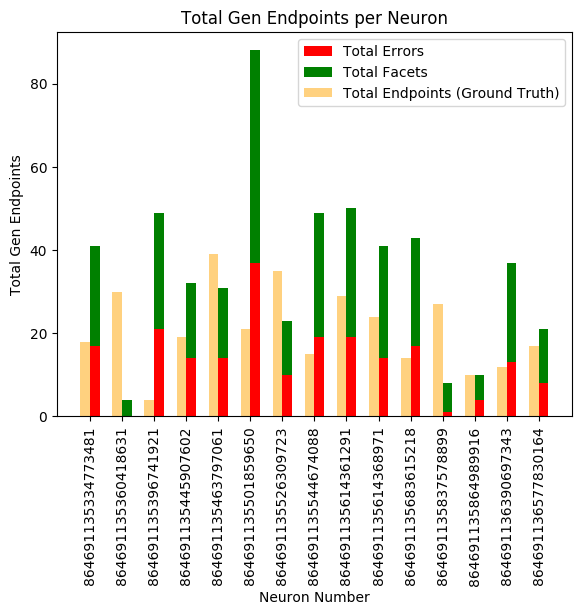

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data from the existing dataframe
existing_neuron_numbers = grouped_data["Neuron"].astype(str)
existing_total_gen_endpoints = grouped_data["total_gen_endpoints"]
existing_total_errors = grouped_data["total_errors"]
existing_total_facets = grouped_data["total_facets"]

# Prepare the data from the ground truth dataframe
ground_truth_neuron_numbers = gt["Neuron "].astype(str)
ground_truth_total_endpoints = gt["Total Endpoints"]

# Set the positions of the bars on the x-axis
x = np.arange(len(existing_neuron_numbers))

# Set the width of the bars
width = 0.3

# Create the figure and axis
fig, ax = plt.subplots()

# Create the bars for existing data
rects2 = ax.bar(x + width, existing_total_errors, width, label='Total Errors', color='red')
rects3 = ax.bar(x + width, existing_total_facets, width, bottom=existing_total_errors, label='Total Facets', color='green')

# Create the bars for ground truth data
rects4 = ax.bar(x, ground_truth_total_endpoints, width, label='Total Endpoints (Ground Truth)', color='orange', alpha=0.5)

# Add labels, title, and legend
ax.set_ylabel('Total Gen Endpoints')
ax.set_xlabel('Neuron Number')
ax.set_title('Total Gen Endpoints per Neuron')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(existing_neuron_numbers)

ax.legend()

# Adjust the layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.xticks(rotation='vertical')
plt.show()

This figure showcases a subset of orphans that were large, mostly spiny, and well-defined. We found our tip generator to function best on these orphans, only overgenerating endpoints by 1-3 if at all (disregarding outliers)

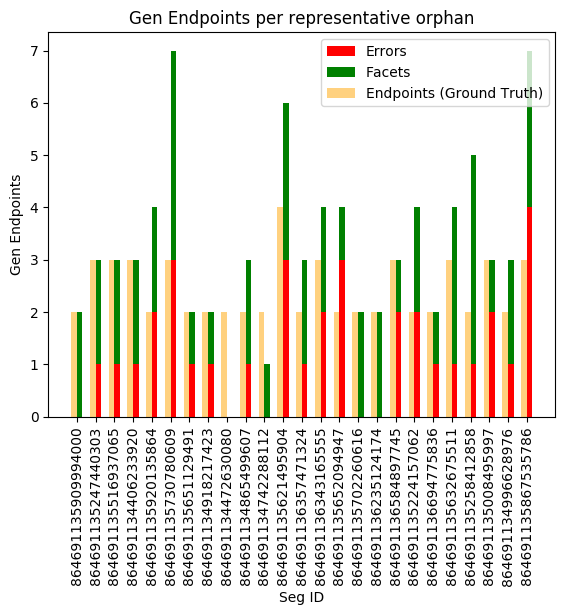

In [35]:
import matplotlib.pyplot as plt
import numpy as np

seg_ids = orphans_subset["seg_id"].astype(str)
num_gen_endpoints = orphans_subset["num_gen_endpoints"]
num_errors = orphans_subset["num_errors"]
num_facets = orphans_subset["num_facets"]

#gt endpoints
ground_truth_neuron_numbers = orphans_subset["neuron"].astype(str)
ground_truth_endpoints = orphans_subset["num_endpoints"]

# Set the positions of the bars on the x-axis
x = np.arange(len(seg_ids))

# Set the width of the bars
width = 0.3

# Create the figure and axis
fig, ax = plt.subplots()

# Create the bars for existing data
rects2 = ax.bar(x + width, num_errors, width, label='Errors', color='red')
rects3 = ax.bar(x + width, num_facets, width, bottom=num_errors, label='Facets', color='green')

# Create the bars for ground truth data
rects4 = ax.bar(x, ground_truth_endpoints, width, label='Endpoints (Ground Truth)', color='orange', alpha=0.5)

# Add labels, title, and legend
ax.set_ylabel('Gen Endpoints')
ax.set_xlabel('Seg ID')
ax.set_title('Gen Endpoints per representative orphan')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(seg_ids)

ax.legend()

# Adjust the layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.xticks(rotation='vertical')
plt.show()

The next figure plots the accuracies for the subset of orphans. Note: we calculated the accuracy based on reasonable euclidian distance to gt endpoints. We did not deduct for overgeneration of endpoints. Although, this was not a major issue with this subset of orphans. 

No handles with labels found to put in legend.


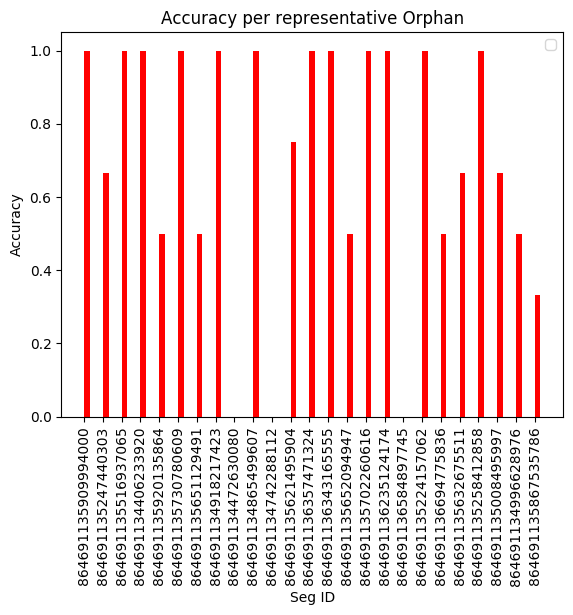

In [36]:
#accuracy plot for subset orphans
import matplotlib.pyplot as plt
import numpy as np

seg_ids = orphans_subset["seg_id"].astype(str)
accuracies = orphans_subset["accuracy"]

# Set the positions of the bars on the x-axis
x = np.arange(len(seg_ids))

# Set the width of the bars
width = 0.3

# Create the figure and axis
fig, ax = plt.subplots()

# Create the bars for existing data
rects2 = ax.bar(x + width, accuracies, width, color='red')


# Add labels, title, and legend
ax.set_ylabel('Accuracy')
ax.set_xlabel('Seg ID')
ax.set_title('Accuracy per representative Orphan')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(seg_ids)

ax.legend()

# Adjust the layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.xticks(rotation='vertical')
plt.show()


The last figure grouped orphans that belong to the same neuron. Frequencies of their accuracies are then displayed. Some orphans were very small and belonged to the same neuron, explaning why some neurons have very high purple bars. 

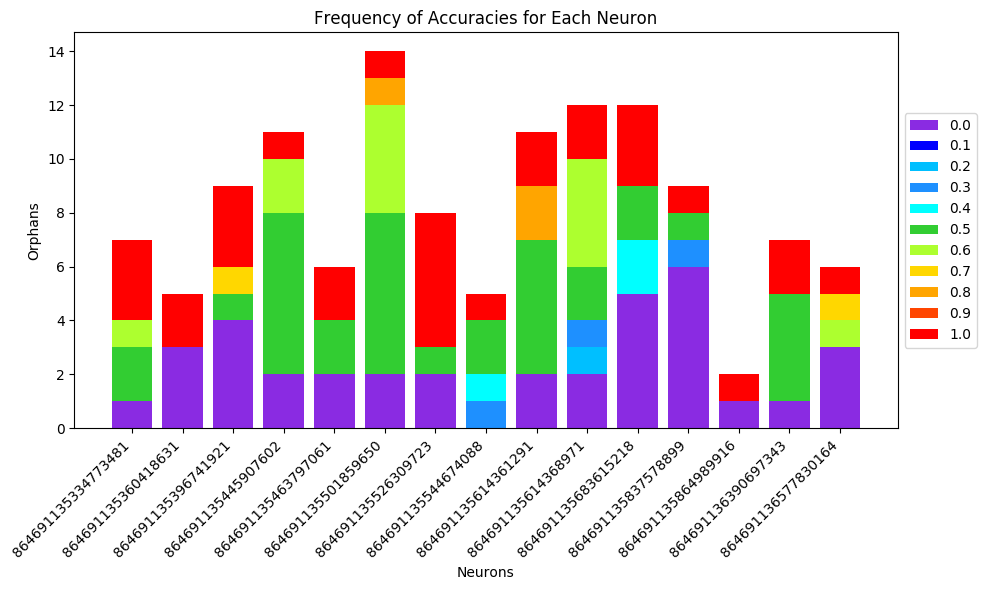

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting data for the chart
neurons = [str(n) for n in grouped_data['Neuron']]
accuracies = grouped_data['all_accuracies']

# Counting the frequency of each accuracy value for each neuron
accuracy_freq = np.zeros((len(neurons), 11))
for i, acc in enumerate(accuracies):
    for val in acc:
        accuracy_freq[i, int(val * 10)] += 1

# Creating the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#8A2BE2', '#0000FF', '#00BFFF', '#1E90FF', '#00FFFF', '#32CD32', '#ADFF2F', '#FFD700', '#FFA500', '#FF4500', '#FF0000']

bars = []
labels = [str(round(a/10, 1)) for a in range(11)]
bottom = np.zeros(len(neurons))
for i in range(11):
    acc_freq = accuracy_freq[:, i]
    bar = ax.bar(neurons, acc_freq, bottom=bottom, color=colors[i])
    bars.append(bar[0])
    bottom += acc_freq

# Legend for the accuracy values
ax.legend(bars, labels, bbox_to_anchor=(1, 0.5), loc='center left')

ax.set_xlabel('Neurons')
ax.set_ylabel('Orphans')
ax.set_title('Frequency of Accuracies for Each Neuron')

# Setting the ticks on the x-axis and rotating labels
ax.set_xticks(neurons)
ax.set_xticklabels(neurons, rotation=45, ha='right')

plt.tight_layout()
plt.show()


### Edge Cases

The 2 images below represent edge cases/errors involvingn skeletonization. Both seg_ids have clear flat regions (facets) that should be considered true endpoints. However, the skeleton (pink) is incorrectly branching. We filter candidate endpoints based on distance to skeleton endpoints. So, even thought the correct facets are found in the first image, they are ultimately filtered out due to the invalid skeleton. The same issue occurs for the second image. Future developers could furhter optimize skeletonization and avoid this invalid branching effect. 

In [37]:
# Load the image
image_path = "campfire/Edge_cases/Edge_case_1.png"
image = Image.open(image_path)
# Display the image
display(image)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/sheeltanna/Desktop/AGT_REPO/campfire/Edge_cases/Edge_case_1.png'

In [ ]:
image_path2 = "campfire/Edge_cases/EdgeCase_1_ex2.png"
image2 = Image.open(image_path2)
display(image2)

The red orphan pictured below represents a class of small, flat orphans that our endpoint detector cannot process. There is no mesh and skeleotn that can be generated for these orphans, resulting in 0% accuracy. These orphans are somehwat common (have some in our gt data) and therefore represent an important edge case. Future developers may choose to focus on larger processes or develop a seperate tool to handle these orphans.  

In [3]:
# Load the image
image_path = "campfire/Edge_cases/Small_edge_case.png"
image = Image.open(image_path)
# Display the image
display(image)

ImportError: dlopen(/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/PIL/_imaging.cpython-38-darwin.so, 0x0002): tried: '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/PIL/_imaging.cpython-38-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e'))